In [3]:
import pandas as pd
import re
from urllib.parse import urlparse

Cleaning work Daan Koppel - 500916607

#PYTHON QUERY 

In [11]:
# Read the Sales Data file
df_SalesData = pd.read_csv('/Users/daan/Desktop/HVA/Database management/salesfinal1.csv',  sep=None, engine='python', encoding='ISO-8859-1')
df_NMovieTable = pd.read_csv('/Users/daan/Desktop/HVA/Database management/NewMovieTable 1.csv', sep=None, engine='python', encoding='ISO-8859-1')

# View the columns to check if it works
#print(df1.columns)

# Drop unnecessary columns from SalesData
df_SalesData = df_SalesData.drop(columns=['year', 'international_box_office', 'domestic_box_office', 'worldwide_box_office', 'release_date', 'Unnamed: 8', 'opening_weekend', 'theatre_count', 'avg run per theatre',
       'runtime', 'production_budget', 'keywords', 'creative_type', 'url'])

def clean_text(text):
    if pd.isna(text):  # Check if the text is NaN
        return ''  # Return an empty string or handle NaN as needed
    # Convert text to lowercase
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text


# Apply the cleaning function to the 'title' column
df_SalesData['title'] = df_SalesData['title'].apply(clean_text)

df_SalesData['normalized_title'] = df_SalesData['title'].apply(clean_text)
df_NMovieTable['normalized_title'] = df_NMovieTable['TITLE'].apply(clean_text)

df_SalesData = df_SalesData.merge(df_NMovieTable[['normalized_title', 'Movie_ID']], 
                                             on='normalized_title', how='left')


df_SalesData = df_SalesData.drop_duplicates()



# Handle NaN values in the 'genre' column by excluding them from the ID assignment
# We'll only assign IDs to rows where 'genre' is not NaN
df_SalesData['genre_id'] = (
    df_SalesData['genre']
    .where(df_SalesData['genre'].notna())  # Keep NaN as NaN
    .groupby(df_SalesData['genre'])
    .ngroup()  # Assign unique integers to each genre group starting from 0
    .astype('Int64')  # Ensures that NaN is retained and non-NaN values are integers
)

# Convert non-NaN values to string and pad with leading zeros, leave NaN as it is
df_SalesData['genre_id'] = (
    df_SalesData['genre_id']
    .apply(lambda x: str(int(x)).zfill(2) if pd.notna(x) else x)  # Format with leading zeros, no prefix
)

# Print the columns and the final DataFrame
print(df_SalesData[['title', 'genre', 'genre_id']].head())

                     title   genre genre_id
0             bakha satang   Drama       06
1                 santitos     NaN      NaN
2  chiedimi se sono felice  Comedy       03
3              raju chacha     NaN      NaN
4    shadow of the vampire   Drama       06


In [12]:
print(df_SalesData['title'].apply(type).value_counts())

title
<class 'str'>    31358
Name: count, dtype: int64


In [13]:
Genre_Sales = df_SalesData[df_SalesData['Movie_ID'].isna()]

print("Unmatched rows in df_SalesData:")
print(Genre_Sales[['title', 'normalized_title']])

Unmatched rows in df_SalesData:
Empty DataFrame
Columns: [title, normalized_title]
Index: []


In [14]:
print(df_SalesData.columns)

Index(['title', 'genre', 'normalized_title', 'Movie_ID', 'genre_id'], dtype='object')


In [15]:
df_Genre_Sales = df_SalesData[['genre_id', 'genre','Movie_ID']]
print(df_Genre_Sales.head())

  genre_id   genre  Movie_ID
0       06   Drama         1
1      NaN     NaN         3
2       03  Comedy     17328
3      NaN     NaN     17329
4       06   Drama     17330


In [22]:
print(df_Genre_Sales.dtypes)


genre_id    object
genre       object
Movie_ID     int64
dtype: object


In [24]:
# Ensure genre_id is numeric, coerce errors to NaN, and then drop NaNs
df_Genre_Sales.loc[:, 'genre_id'] = pd.to_numeric(df_Genre_Sales['genre_id'], errors='coerce')
df_Genre_Sales = df_Genre_Sales.dropna(subset=['genre_id'])

# Convert genre_id to integer after removing NaNs
df_Genre_Sales.loc[:, 'genre_id'] = df_Genre_Sales['genre_id'].astype('int64')

# Reset index after dropping rows
df_Genre_Sales = df_Genre_Sales.reset_index(drop=True)

print(df_Genre_Sales.dtypes)



genre_id     int64
genre       object
Movie_ID     int64
dtype: object


In [25]:
print(df_Genre_Sales[['genre_id', 'Movie_ID']].max())
print(df_Genre_Sales[['genre_id', 'Movie_ID']].min())


genre_id       14
Movie_ID    34415
dtype: int64
genre_id    0
Movie_ID    1
dtype: int64


In [39]:
# Connect to PostgreSQL
conn = psycopg2.connect(
    dbname='DBM',
    user='postgres',
    password='Dk141621?18!',
    host='localhost',
    port='5432'
)

# Create a cursor object
cursor = conn.cursor()

# Update the table creation query with BIGINT for genre_ID and Movie_ID
create_table_query = """
CREATE TABLE IF NOT EXISTS Genre (
    genre_ID TEXT,
    genre TEXT NOT NULL,
    Movie_ID BIGINT PRIMARY KEY
);
"""

# Execute the table creation query
cursor.execute(create_table_query)

# Commit the changes
conn.commit()

# Format genre_id with a leading zero
df_Genre_Sales['genre_id'] = df_Genre_Sales['genre_id'].apply(
    lambda x: f"{int(x):02}" if pd.notna(x) else x
)

# Define the insert query with conflict handling on Movie_ID
insert_query = """
INSERT INTO Genre (genre_ID, genre, Movie_ID)
VALUES (%s, %s, %s)
ON CONFLICT (Movie_ID) DO UPDATE
SET genre = EXCLUDED.genre,
    genre_ID = EXCLUDED.genre_ID;
"""

# Insert data into the table
for index, row in df_Genre_Sales.iterrows():
    try:
        cursor.execute(insert_query, (row['genre_id'], row['genre'], row['Movie_ID']))
    except psycopg2.IntegrityError as e:
        print(f"Error inserting row {index}: {e}")
        conn.rollback()  # Rollback on error
    except psycopg2.DataError as e:
        print(f"Data error inserting row {index}: {e}")
        conn.rollback()  # Rollback on error
    else:
        conn.commit()

# Close the cursor and connection
cursor.close()
conn.close()


In [40]:
df_MovieTable = pd.read_csv ('/Users/daan/Desktop/HVA/Database management/MovieTable.csv', sep=None, engine='python', encoding='ISO-8859-1')     

In [48]:
# Connect to PostgreSQL
conn = psycopg2.connect(
    dbname='DBM',
    user='postgres',
    password='Dk141621?18!',
    host='localhost',
    port='5432'
)

cursor = conn.cursor()

create_table_query="""
CREATE TABLE Movie (
    Movie_ID INTEGER PRIMARY KEY,
    Title TEXT NOT NULL,
    Worldwide_Box_Office FLOAT NOT NULL
);
"""

cursor.execute(create_table_query)

conn.commit()

cursor.close()
conn.close()

In [49]:
import pandas as pd
import psycopg2

# Connect to PostgreSQL
conn = psycopg2.connect(
    dbname='DBM',
    user='postgres',
    password='Dk141621?18!',
    host='localhost',
    port='5432'
)

# Create a cursor object
cursor = conn.cursor()

# Read the CSV file into a DataFrame with a specified encoding
file_path = '/Users/daan/Desktop/HVA/Database management/MovieTable.csv'

# Try different encodings
try:
    df_movie = pd.read_csv(file_path, encoding='utf-8')
except UnicodeDecodeError:
    try:
        df_movie = pd.read_csv(file_path, encoding='ISO-8859-1')
    except UnicodeDecodeError:
        df_movie = pd.read_csv(file_path, encoding='cp1252')

# Convert column names to lowercase to match PostgreSQL column names
df_movie.columns = [col.lower() for col in df_movie.columns]

# Define the insert query
insert_query = """
INSERT INTO Movie (movie_id, title, worldwide_box_office)
VALUES (%s, %s, %s)
ON CONFLICT (movie_id) DO UPDATE
SET title = EXCLUDED.title,
    worldwide_box_office = EXCLUDED.worldwide_box_office;
"""

# Insert data into the table
for index, row in df_movie.iterrows():
    try:
        cursor.execute(insert_query, (row['movie_id'], row['title'], row['worldwide_box_office']))
    except psycopg2.IntegrityError as e:
        print(f"Error inserting row {index}: {e}")
        conn.rollback()  # Rollback on error
    except psycopg2.DataError as e:
        print(f"Data error inserting row {index}: {e}")
        conn.rollback()  # Rollback on error
    else:
        conn.commit()

# Close the cursor and connection
cursor.close()
conn.close()



In [52]:
df_MovieTable = pd.read_csv ('/Users/daan/Desktop/HVA/Database management/MetaTable.csv', sep=None, engine='python', encoding='ISO-8859-1')   

In [53]:
# Connect to PostgreSQL
conn = psycopg2.connect(
    dbname='DBM',
    user='postgres',
    password='Dk141621?18!',
    host='localhost',
    port='5432'
)

cursor = conn.cursor()

create_table_query = """
CREATE TABLE Meta_Table (
    Movie_ID INTEGER PRIMARY KEY,
    MetaScore INTEGER NOT NULL,
    Release_Date DATE NOT NULL
);
"""

cursor.execute(create_table_query)

conn.commit()

cursor.close()
conn.close()

In [59]:
# Connect to PostgreSQL
conn = psycopg2.connect(
    dbname='DBM',
    user='postgres',
    password='Dk141621?18!',
    host='localhost',
    port='5432'
)

# Create a cursor object
cursor = conn.cursor()

# Create the table in PostgreSQL
create_table_query = """
CREATE TABLE IF NOT EXISTS Meta (
    Movie_ID INTEGER PRIMARY KEY,
    MetaScore INTEGER NOT NULL,
    Release_Date DATE NOT NULL
);
"""

cursor.execute(create_table_query)
conn.commit()

# Path to the CSV file
file_path = '/Users/daan/Desktop/HVA/Database management/MetaTable.csv'

# Read the CSV file into a DataFrame with semicolon delimiter
try:
    df_meta = pd.read_csv(file_path, delimiter=';', encoding='utf-8')
except UnicodeDecodeError:
    try:
        df_meta = pd.read_csv(file_path, delimiter=';', encoding='ISO-8859-1')
    except UnicodeDecodeError:
        df_meta = pd.read_csv(file_path, delimiter=';', encoding='cp1252')

# Print column names and first few rows for debugging
print("Column names:", df_meta.columns)
print("First few rows:\n", df_meta.head())

# Convert column names to lowercase to match PostgreSQL column names
df_meta.columns = [col.lower() for col in df_meta.columns]

# Print column names again after conversion
print("Column names after conversion:", df_meta.columns)

# Define the insert query with correct column names
insert_query = """
INSERT INTO Meta (movie_id, metascore, release_date)
VALUES (%s, %s, %s)
ON CONFLICT (movie_id) DO UPDATE
SET metascore = EXCLUDED.metascore,
    release_date = EXCLUDED.release_date;
"""

# Insert data into the table
for index, row in df_meta.iterrows():
    try:
        cursor.execute(insert_query, (row['movie_id'], row['metascore'], row['reldate']))
    except psycopg2.IntegrityError as e:
        print(f"Error inserting row {index}: {e}")
        conn.rollback()  # Rollback on error
    except psycopg2.DataError as e:
        print(f"Data error inserting row {index}: {e}")
        conn.rollback()  # Rollback on error
    except KeyError as e:
        print(f"Key error inserting row {index}: {e}")
    else:
        conn.commit()

# Close the cursor and connection
cursor.close()
conn.close()


Column names: Index(['Movie_ID', 'metascore', 'RelDate'], dtype='object')
First few rows:
    Movie_ID  metascore    RelDate
0     15211         70   2011/6/1
1     29944         70   2011/6/1
2     17228         76  2016/3/11
3     29945         54  2006/12/1
4     10790         61  2012/9/14
Column names after conversion: Index(['movie_id', 'metascore', 'reldate'], dtype='object')


#PART of SQL QUERY

In [64]:
pip install psycopg2-binary

Note: you may need to restart the kernel to use updated packages.


In [65]:
# Connect to PostgreSQL
conn = psycopg2.connect(
    dbname='DBM',
    user='postgres',
    password='Dk141621?18!',
    host='localhost',
    port='5432'
)

# Create a cursor object
cursor = conn.cursor()

# Define the SQL query
sql_query = """
WITH cleaned_data AS (
    SELECT
        m.movie_id,
        m.worldwide_box_office,
        g.genre_id,
        EXTRACT(YEAR FROM mt.release_date) AS release_year
    FROM
        movie m
    JOIN
        genre g ON m.movie_id = g.movie_id
    JOIN
        meta mt ON m.movie_id = mt.movie_id
    WHERE
        m.worldwide_box_office IS NOT NULL
        AND m.worldwide_box_office != 'NaN'
        AND m.worldwide_box_office::text ~ '^[0-9]+(\.[0-9]+)?$'
),
genre_avg AS (
    SELECT
        g.genre_id,
        g.genre,
        c.release_year,
        AVG(c.worldwide_box_office::numeric) AS avg_worldwide_box_office
    FROM
        cleaned_data c
    JOIN
        genre g ON c.genre_id = g.genre_id
    GROUP BY
        g.genre_id, g.genre, c.release_year
)
SELECT
    genre_id,
    genre,
    release_year,
    ROUND(COALESCE(avg_worldwide_box_office, 0), 0) AS avg_worldwide_box_office
FROM
    genre_avg
ORDER BY
    genre_id, release_year;
"""

# Execute the query
cursor.execute(sql_query)

# Fetch the results
results = cursor.fetchall()

# Convert the results to a DataFrame
df = pd.DataFrame(results, columns=['genre_id', 'genre', 'release_year', 'avg_worldwide_box_office'])

# Close the cursor and connection
cursor.close()
conn.close()

# Display the DataFrame
print(df)


<>:14: SyntaxWarning: invalid escape sequence '\.'
<>:14: SyntaxWarning: invalid escape sequence '\.'
/var/folders/2t/4h_j6p2539xbh4t_01l3mzzc0000gn/T/ipykernel_43640/3560077813.py:14: SyntaxWarning: invalid escape sequence '\.'
  sql_query = """


    genre_id    genre release_year avg_worldwide_box_office
0         00   Action         2000                129475723
1         00   Action         2001                183716413
2         00   Action         2002                123529126
3         00   Action         2003                199817779
4         00   Action         2004                138324525
..       ...      ...          ...                      ...
249       14  Western         2016                 51194309
250       14  Western         2017                 47663752
251       14  Western         2018                  4469400
252       14  Western         2019                   638449
253       14  Western         2021                   153686

[254 rows x 4 columns]


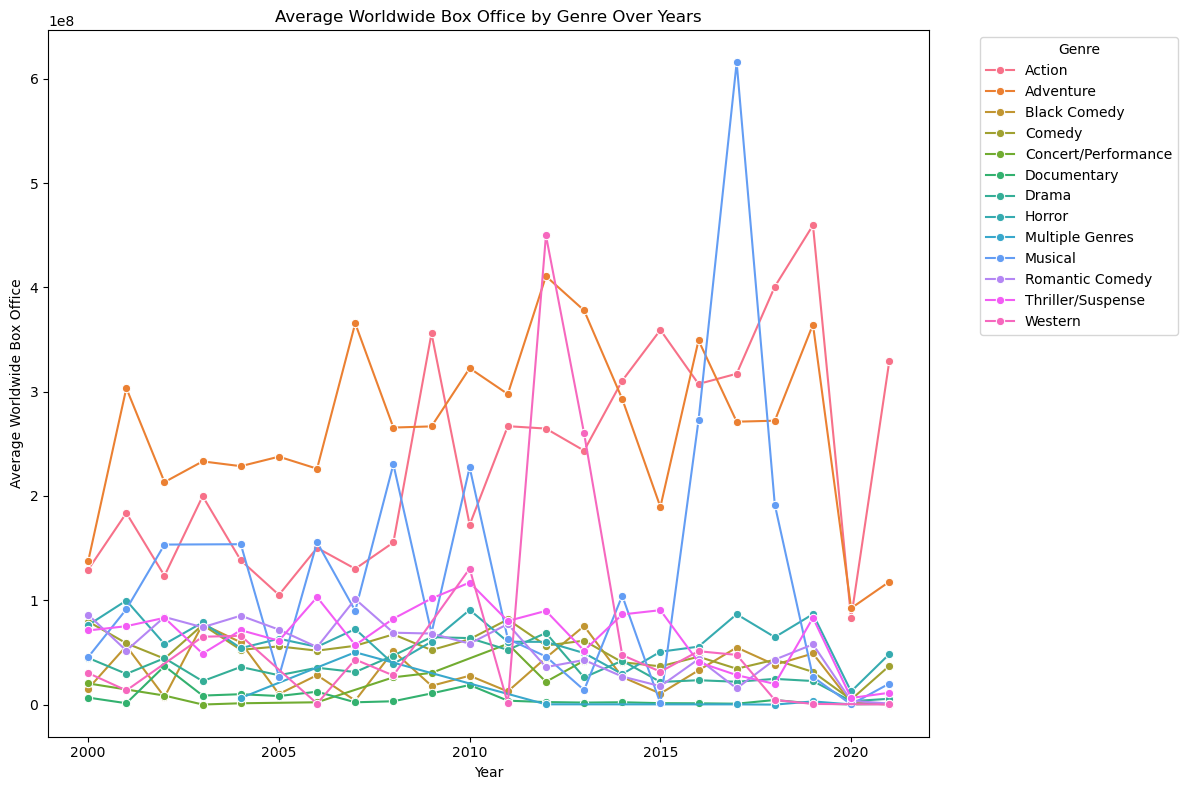

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Create a line plot for each genre
sns.lineplot(data=df, x='release_year', y='avg_worldwide_box_office', hue='genre', marker='o')

# Set the title and labels
plt.title('Average Worldwide Box Office by Genre Over Years')
plt.xlabel('Year')
plt.ylabel('Average Worldwide Box Office')
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()
